In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./mnist/data/', one_hot = True)


Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


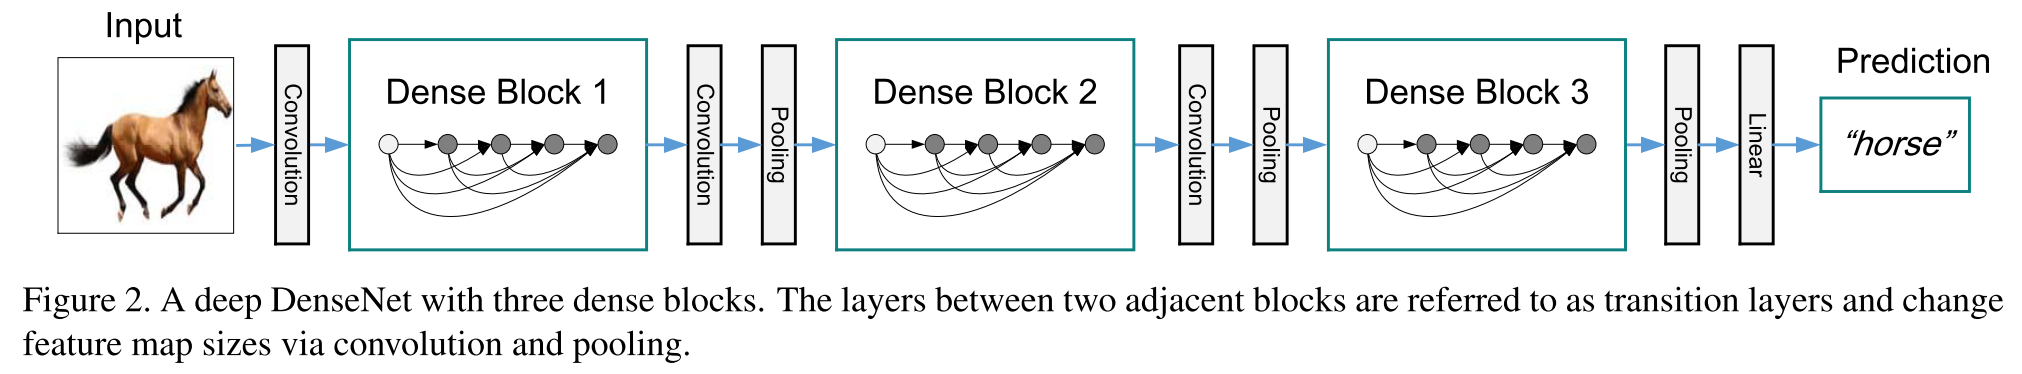

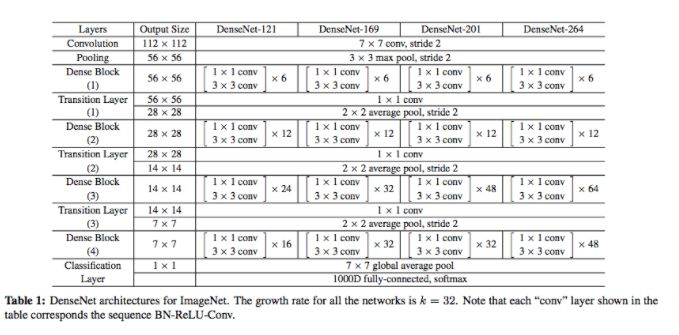


In [1]:

class densenet:
    def __init__(self, params, name):
    
        # 하이퍼파라미터
        self.num_classes = params['num_classes']
        self.start_n_filters = params['start_n_filters']
        self.start_strides = params['start_strides']
        self.growth_rate = params['growth_rate']
        self.n_blocks = params['n_blocks']
        self.is_bottlenecks = params['is_bottlenecks']
        self.theta = params['theta']
        self.layer_number = range(1, len(self.n_blocks) + 1)
        self.keep_probs = params['keep_probs']
        
        self.momentum = params['momentum']
        self.learning_rate = params['learning_rate']

        self.batch_size = params['batch_size']
        self.epochs = params['epochs']
        
        self.height = params['height']
        self.width = params['width']
        self.model_path = params['model_path']
        self.name = name
        self._build_net()
    #residual learning
    # f(x) + x
    # original resnet : 본래 분기되기전에 활성화 함수 적용 
    # densenet :  더하지 않고 concat시켜서 모두 보전

    # batch_norm + 활성화 함수
    def batch_norm_relu(self, inputs, is_training, reuse, name):
        _BN = tf.layers.batch_normalization(inputs, momentum = self.momentum, training= is_training, reuse = reuse, name= name)
        outputs = tf.nn.relu(_BN)
        return outputs

    #Growth rate
    #Layer 의 channel 수
    #너무 wider 하는거 방지, 파라미터 efficiency 를 위해, k = 12 로 제한.
    #실험 해보니 생각보다 작은 k 로 충분한 결과 얻음
    # 보통 bottle_neck을 많이쓰는 이유는 보통 input이 growth_rate보다 높기때문에 계산효율이 떨어지므로
    # conv 1x1 로 4* growth_rate만큼 뻥튀기해서 계산 효율 증가
    # densnet의 블럭   
    # composite_layer [BN --> ReLU -->conv33]
    # composite_layer with bottleneck[BN --> ReLU --> conv1x1 (4k로 뻥튀기) --> _BN --> ReLU -->conv3x3]
    # output n_channel = inputs n_channel + growth_rate (growth_rate만큼 composite_layer를 지나갈때마다 증가)
    def composite_layer(self, inputs, keep_prob, name, is_bottleneck = True, is_training = True, reuse = False):
        L = inputs
        if is_bottleneck:
            L = self.batch_norm_relu(L, is_training, reuse, name = name + '_BN1')
            L = tf.layers.conv2d(L, 4 * self.growth_rate, 1, 1, padding = 'SAME', name = name + '_conv1', reuse = reuse)
        L = self.batch_norm_relu(L, is_training, reuse, name = name + '_BN2')
        L = tf.layers.conv2d(L, self.growth_rate, 3, 1, padding = 'SAME', name = name + '_conv2', reuse = reuse)   
        L = tf.layers.dropout(L, keep_prob, training = is_training)
        return tf.concat([inputs, L], axis = 3) 


    # [BN --> conv11 --> avg_pool2]
    # transition_layer
    # feature맵 크기 줄여주고 compression factor theta에 따라 압축
    def transition_layer(self, inputs, name, is_training = True, reuse= False):
        shape = inputs.get_shape().as_list()
        #compression -> 기존 채널수 * theta(0~1)
        n_filters = int(shape[3] * self.theta)
        L = self.batch_norm_relu(inputs, is_training, reuse, name = name + '_BN')
        L = tf.layers.conv2d(L, n_filters, 1, 1, padding = 'SAME', name = name + '_conv', reuse = reuse)
        L = tf.layers.average_pooling2d(L, 2, 2, name = 'pool')

        return L

    # dense block 생성
    def dense_block(self, inputs, name, n_block, keep_prob, is_training = True, reuse = False):
        L = inputs
        for i in range(n_block):
            L = self.composite_layer(L,
                                     keep_prob,
                                     name = name +'_bottle_neck'+str(i),
                                     is_bottleneck = True,
                                     is_training = is_training,
                                     reuse = reuse)

        return L

    def get_logits(self, inputs, is_training = True, reuse = False):

        # 첫번째는 먼저 conv 3x3 시행 128x32 -> 64 x 16 
        L = tf.layers.conv2d(inputs = inputs,
                             filters = self.start_n_filters,
                             kernel_size = 3,
                             strides = self.start_strides,
                             padding = 'SAME',
                             name = 'begin_conv',
                             reuse = reuse)
        # 크기가 큰경우는 max_pooling을 거치나 여기는 그렇게 크지않으므로 제외
        
        for i, n_block, is_bottleneck, keep_prob in zip(self.layer_number, self.n_blocks, self.is_bottlenecks, self.keep_probs):
            L = self.dense_block(L,
                                 name = 'block'+str(i),
                                 n_block = n_block,
                                 keep_prob=keep_prob,
                                 is_training = is_training,
                                 reuse = reuse)
            # 마지막이 아니면 transitionlayer
            if i < len(self.layer_number):
                L = self.transition_layer(L,
                                          name = 'transition'+str(i),
                                          is_training = is_training,
                                          reuse = reuse)
        
        #마지막 batch_norm and activation function
        outputs = self.batch_norm_relu(L, is_training, reuse, name = 'last__BN')
        # global average_pooling
        # shape : (batch_size, height, width, n_feature_map)
        shape = outputs.get_shape().as_list()
        # 글로벌 풀링 사이즈 (height, width)
        pool_size = (shape[1], shape[2])
        outputs= tf.layers.average_pooling2d(outputs, pool_size = pool_size, strides = 1, padding = 'VALID')
        # 마지막 dense layer
        outputs = tf.layers.flatten(outputs)
        outputs = tf.layers.dense(outputs, 10, name = 'final_dense', reuse=reuse)
        return outputs
 

In [ ]:
   
        
self.X = tf.placeholder(tf.float32, [None, 28, 28, 1])
self.Y = tf.placeholder(tf.float32, [None, 10])
with tf.variable_scope(self.name):
    self.logits_train = self.get_logits(self.X)                              
    self.loss = tf.losses.softmax_cross_entropy(self.Y, self.logits_train)   

            self.logits_eval = self.get_logits(self.X, is_training = False, reuse = True)
            self.predict_proba_ = tf.nn.softmax(self.logits_eval)
            self.prediction = tf.argmax(self.predict_proba_, 1)
            self.global_step = tf.Variable(0, name="global_step", trainable=False)
            self.accuracy = tf.metrics.accuracy(tf.argmax(self.Y, 1), self.prediction)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)            
        with tf.control_dependencies(update_ops):    
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        self.saver = tf.train.Saver(tf.global_variables())

        #accuracy = tf.metrics.accuracy(tf.argmax(Y, 1), prediction)
        # 변수들 프린트/ 텐서보드 summary 생성
        for i, v in enumerate(tf.trainable_variables()):
            print('number : {} )) {}'.format(i, v))        
            
    def fit(self):
        total_batch = int(mnist.train.num_examples/ self.batch_size)
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.local_variables_initializer())
        for epoch in range(10):
            total_cost = 0
        
            for i in range(total_batch):
                batch_xs, batch_ys = mnist.train.next_batch(self.batch_size)
                _, c = sess.run([self.optimizer, self.loss], feed_dict = {self.X:batch_xs.reshape(-1, 28, 28, 1), self.Y: batch_ys})
            acc = sess.run(self.accuracy, feed_dict = {self.X: mnist.test.images.reshape(-1, 28, 28, 1), self.Y: mnist.test.labels})
            
            print('epoch : {}, cost : {}, acc: {}'.format(epoch, c, acc))
        self.saver.save(self.sess, self.model_path+self.name+'.ckpt', global_step = self.sess.run(self.global_step))
        return self

In [8]:
densenet_params = {
    'num_classes': 10,
    'start_n_filters': 16, # 첫 시작 convolution layer의 n_filter
    'start_strides': 2,  # 첫 시작 convolution layer의 strides
    'theta': 1,
    'growth_rate': 12, 
    'n_blocks': [1, 1], # 각 레이어에 할당된블럭의 수 
    'is_bottlenecks': [True, True], # bottle_neck을 사용하면 True
    'keep_probs': [0.8, 0.7], #각 레이어의 드롭아웃
    
    'momentum': 0.9,
    'learning_rate': 0.01,
    'batch_size': 50,
    'epochs': 10,
    'height': 28,
    'width': 28,
    'model_path': './model/tegksjgk/'         
}

In [9]:
tf.reset_default_graph()

model =  densenet(sess, densenet_params, 'model')


number : 0 )) <tf.Variable 'model/begin_conv/kernel:0' shape=(3, 3, 1, 16) dtype=float32_ref>
number : 1 )) <tf.Variable 'model/begin_conv/bias:0' shape=(16,) dtype=float32_ref>
number : 2 )) <tf.Variable 'model/block1_bottle_neck0BN1/gamma:0' shape=(16,) dtype=float32_ref>
number : 3 )) <tf.Variable 'model/block1_bottle_neck0BN1/beta:0' shape=(16,) dtype=float32_ref>
number : 4 )) <tf.Variable 'model/block1_bottle_neck0_conv1/kernel:0' shape=(1, 1, 16, 48) dtype=float32_ref>
number : 5 )) <tf.Variable 'model/block1_bottle_neck0_conv1/bias:0' shape=(48,) dtype=float32_ref>
number : 6 )) <tf.Variable 'model/block1_bottle_neck0BN2/gamma:0' shape=(48,) dtype=float32_ref>
number : 7 )) <tf.Variable 'model/block1_bottle_neck0BN2/beta:0' shape=(48,) dtype=float32_ref>
number : 8 )) <tf.Variable 'model/block1_bottle_neck0_conv2/kernel:0' shape=(3, 3, 48, 12) dtype=float32_ref>
number : 9 )) <tf.Variable 'model/block1_bottle_neck0_conv2/bias:0' shape=(12,) dtype=float32_ref>
number : 10 )) <tf

In [6]:
model.fit()

epoch : 0, cost : 0.4070291817188263, acc: (0.0, 0.83710003)
epoch : 1, cost : 0.4033249616622925, acc: (0.83710003, 0.56445003)
epoch : 2, cost : 0.2562755346298218, acc: (0.56445003, 0.62150002)


KeyboardInterrupt: 

In [ ]:
class resnet:
    def __init__(self, sess, params, model_name):
        self.sess = sess
        self.batch_size = 50
        self.params = params
        self.model_name = model_name
        self._build_net()
        
        
    def _build_net(self):
        learning_rate= self.params['learning_rate']
        batch_size= self.params['batch_size']
        epochs= self.params['epochs']
        height= self.params['height']
        width= self.params['width']
        model_path= self.params['model_path']
        
        self.X = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.Y = tf.placeholder(tf.float32, [None, 10])
        with tf.variable_scope(self.model_name):
            self.logits_train = get_logits(self.X, self.params)                              
            self.loss = tf.losses.softmax_cross_entropy(self.Y, self.logits_train)   

            self.logits_eval = get_logits(self.X, self.params, is_training = False, reuse = True)
            self.predict_proba_ = tf.nn.softmax(self.logits_eval)
            self.prediction = tf.argmax(self.predict_proba_, 1)
            self.global_step = tf.Variable(0, name="global_step", trainable=False)
            self.accuracy = tf.metrics.accuracy(tf.argmax(self.Y, 1), self.prediction)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.model_name)            
        with tf.control_dependencies(update_ops):    
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss, global_step=self.global_step)
        self.saver = tf.train.Saver(tf.global_variables())

        #accuracy = tf.metrics.accuracy(tf.argmax(Y, 1), prediction)
        # 변수들 프린트/ 텐서보드 summary 생성
        for i, v in enumerate(tf.trainable_variables()):
            print('number : {} )) {}'.format(i, v))
            
    def fit(self):
        total_batch = int(mnist.train.num_examples/ self.batch_size)
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.local_variables_initializer())
        for epoch in range(10):
            total_cost = 0
        
            for i in range(total_batch):
                batch_xs, batch_ys = mnist.train.next_batch(self.batch_size)
                _, c = sess.run([self.optimizer, self.loss], feed_dict = {self.X:batch_xs.reshape(-1, 28, 28, 1), self.Y: batch_ys})
            acc = sess.run(self.accuracy, feed_dict = {self.X: mnist.test.images.reshape(-1, 28, 28, 1), self.Y: mnist.test.labels})
            
            print('epoch : {}, cost : {}, acc: {}'.format(epoch, c, acc))
        self.saver.save(self.sess, self.model_path+self.name+'.ckpt', global_step = self.sess.run(self.global_step))
        return self

In [3]:
tf.reset_default_graph()
sess = tf.Session()
model =  resnet(sess, resnet_params, 'model')


NameError: name 'resnet_params' is not defined

In [ ]:
model.fit()

In [ ]:
batch_size = 50
total

In [ ]:
resnet_params = {
    'start_n_filters': 16, # 첫 시작 convolution layer의 n_filter
    'start_strides': 1,  # 첫 시작 convolution layer의 strides
    'n_filters': [16, 32, 64], # 각 레이어에 할당된 filter의 수
    'layers_strides': [1, 2, 2],
    'n_blocks': [2, 2, 2], # 각 레이어에 할당된블럭의 수 
    'is_bottlenecks': [False, False, False], # bottle_neck을 사용하면 True, 일반 residual_net사용한다면 False
    
    'learning_rate': 0.01,
    'batch_size': 50,
    'epochs': 10,
    'height': 28,
    'width': 28,
    'model_path': './model/tegksjgk/'        
}

In [ ]:
with tf.Session() as sess:
    total_batch = int(mnist.train.num_examples/ batch_size)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(10):
        total_cost = 0    
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c, = sess.run([optimizer, loss], feed_dict = {X:batch_xs.reshape(-1, 28, 28, 1), Y: batch_ys})
        acc = sess.run(accuracy, feed_dict = {X: mnist.test.images.reshape(-1, 28, 28, 1), Y: mnist.test.labels})
        
        print('epoch : {}, cost : {}, acc: {}'.format(epoch, c))

In [ ]:
epoch, c

In [ ]:
resnet_params = {
    'num_classes': 10,
    'start_n_filters': 16, # 첫 시작 convolution layer의 n_filter
    'start_strides': 1,  # 첫 시작 convolution layer의 strides
    'n_filters': [16, 32, 64], # 각 레이어에 할당된 filter의 수
    'layers_strides': [1, 2, 2],
    'n_blocks': [2, 2, 2], # 각 레이어에 할당된블럭의 수 
    'is_bottlenecks': [False, False, False], # bottle_neck을 사용하면 True, 일반 residual_net사용한다면 False
    
    'learning_rate': 0.01,
    'batch_size': 50,
    'epochs': 10,
    'height': 28,
    'width': 28,
    'model_path': './model/tegksjgk/'        
}

In [ ]:
def batch_norm(inputs, training, reuse, name):
    return tf.layers.batch_normalization(inputs, training = training, reuse = reuse, name = name + 'BN1')

In [ ]:
class resnet:
    def __init__(self, resnet_params, sess, name):
        self.num_classes = resnet_params['num_classes']
        self.start_n_filters = resnet_params['start_n_filters']
        self.start_strides = resnet_params['start_strides']
        self.n_filters = resnet_params['n_filters']
        self.n_blocks = resnet_params['n_blocks']
        self.is_bottlenecks = resnet_params['is_bottlenecks']
        self.layers_strides = resnet_params['layers_strides']
        self.layer_number = range(1, len(self.n_blocks) + 1)
        
        self.height = resnet_params['height']
        self.width = resnet_params['width']
        
        self.learning_rate = resnet_params['learning_rate']
        self.batch_size = resnet_params['batch_size']   
        self.name = name
        self.sess = sess
        
        self.X = tf.placeholder(tf.float32, [None, self.height, self.width, 1], name="input_x")
        self.Y = tf.placeholder(tf.float32, [None, self.num_classes], name="input_y")
           

        self._build_net()
        
    #residual learning
    # f(x) + x
    # original resnet : 본래 분기되기전에 활성화 함수 적용 
    # this resnet : 분기된 이후 shortcut은 그냥 냅두고 weight path의 weight layer 앞에 활성화함수를 두는 pre_activation 설정
    # regularization 효과

    def residual_unit(self, inputs, n_filter,  strides, name, short_cut = True, is_training = True, reuse = False):
        # 쇼트컷 (residual) 설정
        shortcut = inputs
        if short_cut:
            shortcut = tf.layers.conv2d(inputs = shortcut,
                                        filters = n_filter,
                                        kernel_size= 1,
                                        strides = strides,
                                        padding = 'SAME',
                                        name = name + 'shortcut',
                                        reuse =reuse)

        #pre_activation
        L = batch_norm(inputs, training = is_training, name = name + 'BN1', reuse = reuse)
        L = tf.nn.relu(L)
        
        # convolution (weight layer)
        L = tf.layers.conv2d(inputs = L,
                             filters = n_filter,
                             kernel_size = 3,
                             strides = strides,
                             padding = 'SAME',
                             name = name + 'conv1',
                             reuse = reuse)
        L = batch_norm(L, training = is_training, name = name + 'BN2', reuse = reuse)
        L = tf.nn.relu(L)
        # 블럭의 마지막 layer는 언제나 strides = 1로 하여야한다.
        L = tf.layers.conv2d(inputs = L,
                             filters = n_filter,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'SAME',
                             name = name + 'conv2',
                             reuse = reuse)

        return L + shortcut

     # 학습에 걸리는 시간을 고려해서 50 layer 이상에서는 bottle_neck 구조를 사용한다.
    # bottle_neck구조는 output filter의 갯수가 4배로 증가되어 병부리처럼 보여서 bottle_neck이라고 한다.
    def bottle_neck_unit(self, inputs, n_filter, strides, name, short_cut = True, is_training = True, reuse = False):
        shortcut = inputs
        # bottle_neck 레이어에서는 output filter의 갯수가 input filter 갯수의 4배
        n_filter_out = n_filter
        if short_cut:
            shortcut = tf.layers.conv2d(inputs = shortcut,
                                        filters = n_filter_out,
                                        kernel_size= 1,
                                        strides = strides,
                                        padding = 'SAME',
                                        name = name + 'shortcut',
                                        reuse =reuse)

        # pre_activation
        L =  batch_norm(inputs, training = is_training, name = name + 'BN1', reuse = reuse)
        L = tf.nn.relu(L)
        # 첫번째 레이어 conv 1x1
        L = tf.layers.conv2d(inputs = L,
                             filters = n_filter,
                             kernel_size = 1,
                             strides = 1,
                             padding = 'SAME',
                             name = name + 'conv1',
                             reuse=reuse)

        L =  batch_norm(inputs, training = is_training, name = name + 'BN2', reuse = reuse)
        L = tf.nn.relu(L)
        # 두번쨰 레이어 conv 3x3, strides = strides
        L = tf.layers.conv2d(inputs = L,
                             filters = n_filter,
                             kernel_size = 3,
                             strides = strides,
                             padding = 'SAME',
                             name = name + 'conv2',
                             reuse=reuse)
        L =  batch_norm(inputs, training = is_training, name = name + 'BN3', reuse = reuse)
        L = tf.nn.relu(L)
        # 세번째 레이어 conv 1x1, n_filter x 4
        L = tf.layers.conv2d(inputs = L,
                             filters = n_filter_out,
                             kernel_size = 1,
                             strides = 1,
                             padding = 'SAME',
                             name = name + 'conv3',
                             reuse=reuse)

        return L + shortcut
    

    # 1. params 에서 각 블럭레이어에서 어떤 블럭을 몇개 쌓을 것인지 결정한다.( 34 layer기준 3, 4, 6, 3 residual_net)
    # 2. 첫번째 블럭은 strides를 2로 설정하여 이미지 크기를 줄인다.
    # 3. 나머지 블럭은 strides를 1로 설정.
    def block_layer(self, inputs, n_filter, strides, name, n_block, is_bottleneck = False, is_training = True, reuse = False):
        # bottleneck_layer를 사용한다면
        if is_bottleneck:
            # 첫번째 블럭은 strides 파라미터 받은데로 설정(이미지 크기 1/2)
            L = self.bottle_neck_unit(inputs, n_filter, strides, name+'_bottle_neck_1_', is_training = is_training, reuse = reuse)
            # 나머지 블럭은 strides를 1로 설정(이미지 크기 보존)
            for i in range(2, n_block + 1):
                L = self.bottle_neck_unit(inputs, n_filter, 1, name+'_bottle_neck_'+ str(i) + '_', is_training = is_training, reuse = reuse)
        else:
            # 첫번째 블럭은 strides 파라미터 받은데로 설정(이미지 크기 1/2)
            L = self.residual_unit(inputs, n_filter, strides, name+'_residual_unit_1_', is_training = is_training, reuse = reuse)
            # 나머지 블럭은 strides를 1로 설정(이미지 크기 보존)
            for i in range(2, n_block + 1):
                L = self.residual_unit(inputs, n_filter, 1, name+'_residual_unit_'+ str(i) + '_', is_training = is_training, reuse = reuse)
        return L
    
    
    def get_logits(self, inputs, is_training = True, reuse = False):

        layer_number = range(1, len(self.n_blocks) + 1)


        # 첫번째는 먼저 conv 3x3 시행 128x32 -> 64 x 16 
        conv = tf.layers.conv2d(inputs = inputs,
                             filters = self.start_n_filters,
                             kernel_size = 3,
                             strides = self.start_strides,
                             padding = 'SAME',
                             name = 'begin_conv',
                             reuse = reuse)
        # 크기가 큰경우는 max_pooling을 거치나 여기는 그렇게 크지않으므로 제외
        # strides = [1, 2, 2] 기준
        # 첫번째 layer image size : 64 x16 -> 64 x 16
        # 두번째 layer image size : 64 x 16 -> 32 x 8
        # 세번째 layer image size : 32 x 8 -> 16 x 4
        block = conv
        for i, n_filter, strides, n_block, is_bottleneck in zip(layer_number,
                                                                self.n_filters,
                                                                self.layers_strides,
                                                                self.n_blocks,
                                                                self.is_bottlenecks):
            L = self.block_layer(inputs = block,
                                n_filter = n_filter,
                                strides = strides,
                                name = 'block'+str(i),
                                n_block = n_block,
                                is_bottleneck = is_bottleneck,
                                is_training = is_training,
                                reuse = reuse)
            block = L
     
        #마지막 batch_norm and activation function
        outputs =  batch_norm(block, training = is_training, name='final_BN', reuse = reuse)
        outputs = tf.nn.relu(L)
        # global average_pooling
        # shape : (batch_size, height, width, n_feature_map)
        shape = outputs.get_shape().as_list()
        # 글로벌 풀링 사이즈 (height, width)
        pool_size = (shape[1], shape[2])
        outputs= tf.layers.average_pooling2d(outputs, pool_size = pool_size, strides = 1, padding = 'VALID')
        # 마지막 dense layer
        outputs = tf.layers.flatten(outputs)
        outputs = tf.layers.dense(outputs, self.num_classes, name = 'final_dense', reuse=reuse)
        return outputs
    
    def _build_net(self):
        with tf.variable_scope(self.name):
            self.logits_train = self.get_logits(self.X, resnet_params)                              
            self.loss = tf.losses.softmax_cross_entropy(self.Y, self.logits_train)   

            self.logits_eval = self.get_logits(self.X, is_training = False, reuse = True)
            self.predict_proba_ = tf.nn.softmax(self.logits_eval)
            self.prediction = tf.argmax(self.predict_proba_, 1)
            self.accuracy = tf.metrics.accuracy(tf.argmax(self.Y, 1), self.prediction)
            
            self.global_step = tf.Variable(0, name="global_step", trainable=False)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)            
        with tf.control_dependencies(update_ops):    
            self.optimizer = tf.train.AdamOptimizer(0.03).minimize(loss, global_step=global_step)
        
        for i, v in enumerate(tf.trainable_variables()):
            print('number : {} )) {}'.format(i, v))
    
    def fit(self):
        total_batch = int(mnist.train.num_examples/ self.batch_size)
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.local_variables_initializer())
        for epoch in range(10):
            total_cost = 0
        
            for i in range(total_batch):
                batch_xs, batch_ys = mnist.train.next_batch(self.batch_size)
                _, c = sess.run([self.optimizer, self.loss], feed_dict = {self.X:batch_xs.reshape(-1, 28, 28, 1), self.Y: batch_ys})
            acc = sess.run(self.accuracy, feed_dict = {self.X: mnist.test.images.reshape(-1, 28, 28, 1), self.Y: mnist.test.labels})
            
            print('epoch : {}, cost : {}, acc: {}'.format(epoch, c, acc))
        return self
        

In [ ]:
tf.reset_default_graph()
sess = tf.Session()
model = resnet(resnet_params, sess, name = 'model')

In [ ]:
a = [3, 4, 5]
b = [7, 8, 9]

In [ ]:
for i, j, k in zip(range(1, len(a) +1 ),a, b):
    print(i, j, k)

In [ ]:
128,32
64, 16
32, 8
16, 4

In [ ]:
#hyperparameter
params = {
    'num_classes': 10,
    
    'num_filters': [8, 16, 32],
    'filter_size': [2, 2, 2],
    'cnn_batch_norm' : [False, False, False],
    
    'fc_hidden_units': [256, 128],
    'fc_batch_norm': [False, False],
    'fc_dropout_keep_prob': [0.2, 0.3],
    
    'rnn_n_step': 28, #width, time
    'rnn_n_hiddens': [128, 128],
    'rnn_dropout_keep_prob': [0.5, 0.6],
    
    'learning_rate': 0.01,
    'activation' : tf.nn.relu,
    'batch_size': 100
}
tf.reset_default_graph()

class Model(object):

    def __init__(self, params, sess, name):
        # 하이퍼파라미터
        self.num_classes = params['num_classes']
        self.num_filters = params['num_filters']
        self.filter_sizes = params['filter_size']
        self.cnn_batch_norm  = params['cnn_batch_norm']
        
        self.fc_hidden_units = params['fc_hidden_units']
        self.fc_batch_norm = params['fc_batch_norm']
        self.fc_dropout_keep_prob = params['fc_dropout_keep_prob']
        
        self.rnn_n_hiddens = params['rnn_n_hiddens']
        self.rnn_dropout_keep_prob = params['rnn_dropout_keep_prob']
        
        self.learning_rate = params['learning_rate']
        self.activation = params['activation']
        self.batch_size = params['batch_size']        
        
        self.idx_convolutional_layers = range(1, len(self.filter_sizes) + 1)
        self.idx_fc_layers = range(1, len(self.fc_hidden_units) + 1)
        self.idx_rnn_layers = range(1, len(self.rnn_n_hiddens) + 1)

        self.name = name
        self.sess = sess
        # 플레이스홀더
        with tf.device('/gpu:0'):
            self.X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="input_x")
            self.Y = tf.placeholder(tf.float32, [None, self.num_classes], name="input_y")
            

            self._build_net()

        
        
    #  컨볼루션 레이어를 params에서 받은 파라미터를 따라 구축
    def convolutional_layers(self, X, is_training = True, reuse = False):
        inputs = X
        for i, num_filter, filter_size, use_bn in zip(self.idx_convolutional_layers, self.num_filters, self.filter_sizes, self.cnn_batch_norm):            
            L = tf.layers.conv2d(inputs,
                                 filters=num_filter,
                                 kernel_size=filter_size,
                                 strides=1,
                                 padding='SAME',
                                 name = 'CONV'+str(i),
                                 reuse= reuse)
            if use_bn:
                L= tf.layers.batch_normalization(L, training= is_training, name='BN' + str(i), reuse= reuse)
            L = self.activation(L)
            L = tf.layers.max_pooling2d(L, pool_size = 2, strides = 2, padding = 'SAME')
            inputs = L
        return inputs
    
    
    #  dense 레이어를 params에서 받은 파라미터를 따라 구축
    def fc_layers(self, X, is_training = True, reuse = False):
        inputs = X
        for i, units, use_bn, keep_prob in zip(self.idx_fc_layers, self.fc_hidden_units, self.fc_batch_norm, self.fc_dropout_keep_prob):
            fc = tf.layers.dense(inputs,
                                 units=units,
                                 reuse=reuse,
                                 name = 'FC' + str(i))
            if use_bn:
                fc = tf.layers.batch_normalization(fc, training= is_training, name='fc_BN' + str(i), reuse= reuse)
            fc = self.activation(fc)
            if keep_prob:
                fc = tf.layers.dropout(fc, rate = keep_prob, training= is_training, name = 'fc_dropout' + str(i))
            inputs = fc 
        return inputs
  

     # LSTM 레이어 
    def rnn_layers(self, inputs, is_training = True, reuse = False):
        if is_training:
            keep_probs = self.rnn_dropout_keep_prob
            
        else:
            keep_probs = np.ones_like(self.rnn_dropout_keep_prob)
        # single layer
        if len(self.idx_rnn_layers) == 1:
            cell = tf.nn.rnn_cell.BasicLSTMCell(self.rnn_n_hiddens[0], reuse = reuse)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_probs[0])
        # multi layer 
        else:
            cell_list = []
            for i, n_hidden, keep_prob in zip(self.idx_rnn_layers, self.rnn_n_hiddens, keep_probs):
                cell_ = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, reuse = reuse)
                cell_ = tf.nn.rnn_cell.DropoutWrapper(cell_, output_keep_prob=keep_prob)
                cell_list.append(cell_)
            cell = tf.nn.rnn_cell.MultiRNNCell(cell_list)
        # output_shape [batch_size, width(n_step), n_classes]
        outputs, states = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
        print(outputs.get_shape().as_list())
        outputs = tf.transpose(outputs, [1, 0, 2])
        outputs = outputs[-1]
        return outputs
 

    def get_reshaped_cnn_to_rnn(self, inputs):
        # [batch, height, width, n_feature map]
        shape = inputs.get_shape().as_list() 
        # 우리가 얻어야하는 사이즈 [batch, height, width x n_feature map]
        reshaped_inputs = tf.reshape(inputs, [-1, shape[1], shape[2] * shape[3]])
        return reshaped_inputs
  


    # 모델 구축/ logit 
    def get_logits(self, X, is_training = True, reuse = False):        
        conv = self.convolutional_layers(self.X, is_training, reuse)                           
        #flat = tf.layers.flatten(conv)
        reshaped_fp = self.get_reshaped_cnn_to_rnn(conv)
        rnn = self.rnn_layers(reshaped_fp, is_training, reuse)
        #fc = self.fc_layers(flat, is_training, reuse)
        output = tf.layers.dense(rnn, units= self.num_classes, reuse=reuse, name = 'out')
        
        return output
 


    # 모델 구축
    def _build_net(self):
        
        with tf.variable_scope(self.name):
            self.logits_train = self.get_logits(self.X)                              
            self.loss = tf.losses.softmax_cross_entropy(self.Y, self.logits_train)   
                # batch_normalization 적용을 위해 모든 변수들을 불러와서 moving
                #학습 단계에서는 데이터가 배치 단위로 들어오기 때문에 배치의 평균, 분산을 구하는 것이 가능하지만,
                # 테스트 단계에서는 배치 단위로 평균/분산을 구하기가 어렵기때문에
                # 학습 단계에서 배치 단위의 평균/분산을 저장해 놓고 테스트 시에는 평균/분산을 사용합니다.
                # 저장한 값을 get_collection을 통해서 불러온다.
            self.global_step = tf.Variable(0, name="global_step", trainable=False)
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)            
            with tf.control_dependencies(update_ops):    
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

            self.logits_eval = self.get_logits(self.X, is_training = False, reuse = True)
            self.predict_proba_ = tf.nn.softmax(self.logits_eval)
            self.prediction = tf.argmax(self.predict_proba_, 1)
            self.accuracy = tf.metrics.accuracy(tf.argmax(self.Y, 1), self.prediction)
            # 변수들 프린트/ 텐서보드 summary 생성
        tf.summary.scalar('loss', self.loss)
        # tf.summary.scalar('accuracy', self.accuracy[1])
        for v in tf.trainable_variables():
            tf.summary.histogram('Var_{}'.format(v.name), v)
            print(v)            
        self.merged = tf.summary.merge_all()
        # 모델저장
        saver = tf.train.Saver()
            
        
    def fit(self):
        total_batch = int(mnist.train.num_examples/ self.batch_size)
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.local_variables_initializer())
        writer = tf.summary.FileWriter('./logs/', sess.graph)
        for epoch in range(10):
            total_cost = 0
        
            for i in range(total_batch):
                batch_xs, batch_ys = mnist.train.next_batch(self.batch_size)
                _, c, _summ = sess.run([self.optimizer, self.loss, self.merged], feed_dict = {self.X:batch_xs.reshape(-1, 28, 28, 1), self.Y: batch_ys})
                writer.add_summary(_summ, i)
            #acc = sess.run(self.accuracy, feed_dict = {self.X: mnist.test.images.reshape(-1, 28, 28, 1), self.Y: mnist.test.labels})
            
            print('epoch : {}, cost : {}, acc: {}'.format(epoch, c))
        return self

In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:

model = Model(params, sess, name = 'model')

In [ ]:
model.fit()
sess.close()

In [ ]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

In [ ]:
sess = tf.Session(config=tf.ConfigProto(
      allow_soft_placement=True, log_device_placement=True))
# Runs the op.
print(sess.run(c))

In [ ]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev = 0.01))
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev = 0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

L2_flatten = tf.contrib.layers.flatten(L2)

W3 = tf.Variable(tf.random_normal([7 * 7 * 64, 256], stddev = 0.01))
b3 = tf.Variable(tf.random_normal([256]))
L3 = tf.nn.relu(tf.matmul(L2_flatten, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob)

W4 = tf.Variable(tf.random_normal([256, 10], stddev =0.01))
b4 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L3, W4) + b4

cost = tf.losses.softmax_cross_entropy(Y, logits = logits)
train = tf.train.AdamOptimizer(0.001).minimize(cost)


predictions = tf.argmax(tf.nn.softmax(logits), 1)
accuracy = tf.metrics.accuracy(tf.argmax(Y, 1), predictions)

batch_size = 100
with tf.Session() as sess:
    total_batch = int(mnist.train.num_examples/ batch_size)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(15):
        total_cost = 0
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c, = sess.run([train, cost], feed_dict = {X:batch_xs.reshape(-1, 28, 28, 1), Y: batch_ys, keep_prob: 0.8})
        acc = sess.run([accuracy], feed_dict = {X: mnist.test.images.reshape(-1, 28, 28, 1), Y: mnist.test.labels, keep_prob: 1.0})
        print('epoch : {}, cost : {}, acc: {}'.format(epoch, c, acc))
            
            


In [ ]:
tf.reset_default_graph()

In [ ]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

def model_net(x, activation, is_training, reuse = False):
    L1 = tf.layers.conv2d(x, 32, 3, padding='SAME', activation = activation, reuse= reuse, name = 'L1')
    L1 = tf.layers.max_pooling2d(L1, 2, 2)
    L2 = tf.layers.conv2d(L1, 64, 3, padding='SAME', activation = activation, reuse=reuse, name = 'L2')
    L2 = tf.layers.max_pooling2d(L2, 2, 2)
    
    L2_flatten = tf.contrib.layers.flatten(L2)
    
    fc1 = tf.layers.dense(L2_flatten, 256, activation = activation, reuse=reuse, name = 'FC1')
    fc1 = tf.layers.dropout(fc1, 0.2, training = is_training)
    
    fc2 = tf.layers.dense(fc1, 10, reuse=reuse, name = 'output')
    return fc2


In [ ]:
logits = model_net(X, tf.nn.relu, True)
test_logits = model_net(X, tf.nn.relu, False, True)
cost = tf.losses.softmax_cross_entropy(Y, logits = logits)
train = tf.train.AdamOptimizer(0.001).minimize(cost)


predictions = tf.argmax(tf.nn.softmax(test_logits), 1)
accuracy = tf.metrics.accuracy(tf.argmax(Y, 1), predictions)

In [ ]:
batch_size = 100
with tf.Session() as sess:
    total_batch = int(mnist.train.num_examples/ batch_size)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(15):
        total_cost = 0
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c, = sess.run([train, cost], feed_dict = {X:batch_xs.reshape(-1, 28, 28, 1), Y: batch_ys})
        acc = sess.run([accuracy], feed_dict = {X: mnist.test.images.reshape(-1, 28, 28, 1), Y: mnist.test.labels})
        print('epoch : {}, cost : {}, acc: {}'.format(epoch, c, acc))
            
          

In [ ]:
tf.reset_default_graph()

In [ ]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

def model_net(x, activation, is_training, reuse = False):
    L1 = tf.layers.conv2d(x, 32, 3, padding='SAME', reuse= reuse, name = 'L1')
    L1 = tf.layers.batch_normalization(L1, training=is_training)
    L1 = activation(L1)
    L1 = tf.layers.max_pooling2d(L1, 2, 2)
    
    L2 = tf.layers.conv2d(L1, 64, 3, padding='SAME', activation = activation, reuse=reuse, name = 'L2')
    L2 = tf.layers.batch_normalization(L2, training=is_training)
    L2 = activation(L2)
    L2 = tf.layers.max_pooling2d(L2, 2, 2)
    
    L2_flatten = tf.contrib.layers.flatten(L2)
    
    fc1 = tf.layers.dense(L2_flatten, 256, activation = activation, reuse=reuse, name = 'FC1')
    fc1 = tf.layers.dropout(fc1, 0.2, training = is_training)
    
    fc2 = tf.layers.dense(fc1, 10, reuse=reuse, name = 'output')
    return fc2


In [ ]:
logits = model_net(X, tf.nn.relu, True)
test_logits = model_net(X, tf.nn.relu, False, True)
cost = tf.losses.softmax_cross_entropy(Y, logits = logits)
train = tf.train.AdamOptimizer(0.001).minimize(cost)


predictions = tf.argmax(tf.nn.softmax(test_logits), 1)
accuracy = tf.metrics.accuracy(tf.argmax(Y, 1), predictions)

In [ ]:
batch_size = 100
with tf.Session() as sess:
    total_batch = int(mnist.train.num_examples/ batch_size)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(15):
        total_cost = 0
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c, = sess.run([train, cost], feed_dict = {X:batch_xs.reshape(-1, 28, 28, 1), Y: batch_ys})
        acc = sess.run([accuracy], feed_dict = {X: mnist.test.images.reshape(-1, 28, 28, 1), Y: mnist.test.labels})
        print('epoch : {}, cost : {}, acc: {}'.format(epoch, c, acc))          